# Skin Lesion Classification — Transfer Learning template
**Dataset:** merged HAM10000 + MSLDv2.0 (14 classes).

This notebook trains a single transfer-learning model on the dataset using PyTorch. 
**Assumptions:** dataset arranged like:
```
data/
  train/
    class_1/
      img1.jpg
      img2.jpg
    class_2/
  val/
    class_1/
    ...
```
If your dataset is packaged differently, adapt `train_dir` / `val_dir` variables below.

This notebook was autogenerated to match SE4050 assignment requirements (4 different model notebooks will be provided).
\n\n**Model:** MobileNetV3-Large

In [1]:
# Environment & imports
# If running in a fresh environment, you may need to install packages:
# !pip install torch torchvision matplotlib scikit-learn tqdm timm -q
%pip install torch torchvision matplotlib scikit-learn tqdm timm
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Note: you may need to restart the kernel to use updated packages.
Device: cpu


In [2]:
# Paths (change these to your dataset locations)
# Download and extract your dataset folders locally, then set the paths below:
train_dir = r"D:\archive\train"
val_dir   = r"D:\archive\val"   # Example local path

# Data transforms and augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes ({}):".format(num_classes), class_names)
print("Train size:", len(train_dataset), " Val size:", len(val_dataset))


Classes (14): ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Melanocytic nevi', 'Melanoma', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train size: 29322  Val size: 3660


In [3]:
# Compute class weights to address imbalance
from collections import Counter
counts = Counter([y for _, y in train_dataset.samples])
counts = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts)
class_weights = torch.tensor([sum(counts)/c for c in counts], dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [693, 2658, 2099, 900, 792, 191, 1932, 1368, 660, 10300, 3617, 3408, 502, 202]
Class weights: tensor([ 42.3117,  11.0316,  13.9695,  32.5800,  37.0227, 153.5183,  15.1770,
         21.4342,  44.4273,   2.8468,   8.1067,   8.6039,  58.4104, 145.1584])


In [4]:
# MobileNetV3 Large (pretrained)
try:
    model = models.mobilenet_v3_large(pretrained=True)
    # Correctly identify the input features for the classifier
    num_ftrs = model.classifier[-1].in_features  # Access the last layer of the classifier
    model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
except Exception as e:
    # Fallback for older torchvision versions or different model structures
    model = models.mobilenet_v3_large(pretrained=True)
    # Attempt to access the in_features from the first layer if the above fails
    try:
        num_ftrs = model.classifier[0].in_features
        model.classifier[0] = nn.Linear(num_ftrs, num_classes)
    except Exception as e_fallback:
        print(f"Could not adapt classifier automatically: {e_fallback}")
        print("Please check the model's classifier structure and adapt the code manually.")

model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to C:\Users\nethm/.cache\torch\hub\checkpoints\mobilenet_v3_large-8738ca79.pth


c:\Users\nethm\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nethm\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 21.1M/21.1M [01:40<00:00, 221kB/s]


In [5]:
# Optimizer, scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Optional scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = None
num_epochs = 30  # change as needed


In [6]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=30, model_name="model"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[], "val_f1":[]}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        # Each epoch has a training and validation phase
        for phase in ["train","val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []

            for inputs, labels in tqdm(loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(preds.cpu().numpy().tolist())

            epoch_loss = running_loss / (len(loader.dataset))
            epoch_acc = running_corrects / (len(loader.dataset))
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            print("{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}".format(phase, epoch_loss, epoch_acc, epoch_f1))

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                # deep copy the model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
        if scheduler is not None:
            scheduler.step()
        print("-"*30)

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val F1: {:.4f}".format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [7]:
# Train
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, model_name="MobileNetV3-Large")


Epoch 1/30


100%|██████████| 917/917 [17:38<00:00,  1.15s/it]


train Loss: 1.2843 Acc: 0.5360 F1: 0.4528


100%|██████████| 115/115 [00:46<00:00,  2.47it/s]


val Loss: 0.8981 Acc: 0.6719 F1: 0.5954
------------------------------
Epoch 2/30


100%|██████████| 917/917 [17:59<00:00,  1.18s/it]


train Loss: 0.8871 Acc: 0.6377 F1: 0.5747


100%|██████████| 115/115 [01:09<00:00,  1.67it/s]


val Loss: 0.7205 Acc: 0.7415 F1: 0.6894
------------------------------
Epoch 3/30


100%|██████████| 917/917 [20:56<00:00,  1.37s/it]


train Loss: 0.7555 Acc: 0.6813 F1: 0.6270


100%|██████████| 115/115 [01:24<00:00,  1.37it/s]


val Loss: 0.7231 Acc: 0.7298 F1: 0.6675
------------------------------
Epoch 4/30


100%|██████████| 917/917 [17:56<00:00,  1.17s/it] 


train Loss: 0.6668 Acc: 0.7071 F1: 0.6587


100%|██████████| 115/115 [00:46<00:00,  2.49it/s]


val Loss: 0.6158 Acc: 0.7683 F1: 0.7371
------------------------------
Epoch 5/30


100%|██████████| 917/917 [15:45<00:00,  1.03s/it]


train Loss: 0.6193 Acc: 0.7214 F1: 0.6768


100%|██████████| 115/115 [00:47<00:00,  2.44it/s]


val Loss: 0.6474 Acc: 0.7541 F1: 0.7288
------------------------------
Epoch 6/30


100%|██████████| 917/917 [15:41<00:00,  1.03s/it]


train Loss: 0.5763 Acc: 0.7381 F1: 0.7004


100%|██████████| 115/115 [00:45<00:00,  2.53it/s]


val Loss: 0.5986 Acc: 0.7792 F1: 0.7454
------------------------------
Epoch 7/30


100%|██████████| 917/917 [15:02<00:00,  1.02it/s]


train Loss: 0.5393 Acc: 0.7514 F1: 0.7125


100%|██████████| 115/115 [00:45<00:00,  2.51it/s]


val Loss: 0.5611 Acc: 0.7921 F1: 0.7888
------------------------------
Epoch 8/30


100%|██████████| 917/917 [15:00<00:00,  1.02it/s]


train Loss: 0.5142 Acc: 0.7583 F1: 0.7232


100%|██████████| 115/115 [00:44<00:00,  2.60it/s]


val Loss: 0.5607 Acc: 0.7883 F1: 0.7569
------------------------------
Epoch 9/30


100%|██████████| 917/917 [15:00<00:00,  1.02it/s]


train Loss: 0.4786 Acc: 0.7733 F1: 0.7426


100%|██████████| 115/115 [00:45<00:00,  2.53it/s]


val Loss: 0.4908 Acc: 0.8180 F1: 0.8025
------------------------------
Epoch 10/30


100%|██████████| 917/917 [15:00<00:00,  1.02it/s]


train Loss: 0.4578 Acc: 0.7761 F1: 0.7473


100%|██████████| 115/115 [00:44<00:00,  2.59it/s]


val Loss: 0.5111 Acc: 0.8109 F1: 0.7776
------------------------------
Epoch 11/30


100%|██████████| 917/917 [15:01<00:00,  1.02it/s]


train Loss: 0.4318 Acc: 0.7867 F1: 0.7619


100%|██████████| 115/115 [00:45<00:00,  2.50it/s]


val Loss: 0.5307 Acc: 0.8087 F1: 0.7925
------------------------------
Epoch 12/30


100%|██████████| 917/917 [15:00<00:00,  1.02it/s]


train Loss: 0.4068 Acc: 0.7948 F1: 0.7723


100%|██████████| 115/115 [00:44<00:00,  2.56it/s]


val Loss: 0.5179 Acc: 0.8191 F1: 0.8008
------------------------------
Epoch 13/30


100%|██████████| 917/917 [15:02<00:00,  1.02it/s]


train Loss: 0.3980 Acc: 0.8010 F1: 0.7796


100%|██████████| 115/115 [00:47<00:00,  2.44it/s]


val Loss: 0.4810 Acc: 0.8314 F1: 0.7999
------------------------------
Epoch 14/30


100%|██████████| 917/917 [15:05<00:00,  1.01it/s]


train Loss: 0.3742 Acc: 0.8060 F1: 0.7872


100%|██████████| 115/115 [00:44<00:00,  2.61it/s]


val Loss: 0.4674 Acc: 0.8358 F1: 0.8071
------------------------------
Epoch 15/30


100%|██████████| 917/917 [14:50<00:00,  1.03it/s]


train Loss: 0.3815 Acc: 0.8055 F1: 0.7845


100%|██████████| 115/115 [00:46<00:00,  2.47it/s]


val Loss: 0.4719 Acc: 0.8246 F1: 0.8004
------------------------------
Epoch 16/30


100%|██████████| 917/917 [14:56<00:00,  1.02it/s]


train Loss: 0.3701 Acc: 0.8099 F1: 0.7874


100%|██████████| 115/115 [00:43<00:00,  2.65it/s]


val Loss: 0.4718 Acc: 0.8385 F1: 0.8017
------------------------------
Epoch 17/30


100%|██████████| 917/917 [15:01<00:00,  1.02it/s]


train Loss: 0.3647 Acc: 0.8156 F1: 0.7975


100%|██████████| 115/115 [00:44<00:00,  2.59it/s]


val Loss: 0.4363 Acc: 0.8388 F1: 0.8441
------------------------------
Epoch 18/30


100%|██████████| 917/917 [15:09<00:00,  1.01it/s]


train Loss: 0.3461 Acc: 0.8188 F1: 0.7992


100%|██████████| 115/115 [00:43<00:00,  2.67it/s]


val Loss: 0.3907 Acc: 0.8620 F1: 0.8579
------------------------------
Epoch 19/30


100%|██████████| 917/917 [14:54<00:00,  1.03it/s]


train Loss: 0.3262 Acc: 0.8271 F1: 0.8105


100%|██████████| 115/115 [00:45<00:00,  2.52it/s]


val Loss: 0.4580 Acc: 0.8413 F1: 0.8306
------------------------------
Epoch 20/30


100%|██████████| 917/917 [14:46<00:00,  1.03it/s]


train Loss: 0.3208 Acc: 0.8312 F1: 0.8147


100%|██████████| 115/115 [00:44<00:00,  2.60it/s]


val Loss: 0.4176 Acc: 0.8538 F1: 0.8444
------------------------------
Epoch 21/30


100%|██████████| 917/917 [15:00<00:00,  1.02it/s]


train Loss: 0.3192 Acc: 0.8346 F1: 0.8128


100%|██████████| 115/115 [00:45<00:00,  2.55it/s]


val Loss: 0.4069 Acc: 0.8525 F1: 0.8506
------------------------------
Epoch 22/30


100%|██████████| 917/917 [15:01<00:00,  1.02it/s]


train Loss: 0.2961 Acc: 0.8401 F1: 0.8259


100%|██████████| 115/115 [00:43<00:00,  2.64it/s]


val Loss: 0.3868 Acc: 0.8604 F1: 0.8436
------------------------------
Epoch 23/30


100%|██████████| 917/917 [14:41<00:00,  1.04it/s]


train Loss: 0.2913 Acc: 0.8433 F1: 0.8274


100%|██████████| 115/115 [00:44<00:00,  2.59it/s]


val Loss: 0.4101 Acc: 0.8464 F1: 0.8280
------------------------------
Epoch 24/30


100%|██████████| 917/917 [15:09<00:00,  1.01it/s]


train Loss: 0.2884 Acc: 0.8450 F1: 0.8357


100%|██████████| 115/115 [00:46<00:00,  2.46it/s]


val Loss: 0.4512 Acc: 0.8549 F1: 0.8123
------------------------------
Epoch 25/30


100%|██████████| 917/917 [14:51<00:00,  1.03it/s]


train Loss: 0.2889 Acc: 0.8454 F1: 0.8286


100%|██████████| 115/115 [00:43<00:00,  2.64it/s]


val Loss: 0.3974 Acc: 0.8598 F1: 0.8513
------------------------------
Epoch 26/30


100%|██████████| 917/917 [14:56<00:00,  1.02it/s]


train Loss: 0.2730 Acc: 0.8515 F1: 0.8412


100%|██████████| 115/115 [00:56<00:00,  2.04it/s]


val Loss: 0.4245 Acc: 0.8549 F1: 0.8564
------------------------------
Epoch 27/30


100%|██████████| 917/917 [17:06<00:00,  1.12s/it]


train Loss: 0.2769 Acc: 0.8545 F1: 0.8391


100%|██████████| 115/115 [00:46<00:00,  2.45it/s]


val Loss: 0.4163 Acc: 0.8639 F1: 0.8543
------------------------------
Epoch 28/30


100%|██████████| 917/917 [16:27<00:00,  1.08s/it]


train Loss: 0.2714 Acc: 0.8524 F1: 0.8363


100%|██████████| 115/115 [00:56<00:00,  2.02it/s]


val Loss: 0.4275 Acc: 0.8467 F1: 0.8405
------------------------------
Epoch 29/30


100%|██████████| 917/917 [16:35<00:00,  1.09s/it]


train Loss: 0.2543 Acc: 0.8581 F1: 0.8464


100%|██████████| 115/115 [00:51<00:00,  2.25it/s]


val Loss: 0.3915 Acc: 0.8694 F1: 0.8624
------------------------------
Epoch 30/30


100%|██████████| 917/917 [15:30<00:00,  1.01s/it]


train Loss: 0.2595 Acc: 0.8584 F1: 0.8450


100%|██████████| 115/115 [00:42<00:00,  2.72it/s]

val Loss: 0.3807 Acc: 0.8724 F1: 0.8675
------------------------------
Training complete in 495m 17s
Best val F1: 0.8675


In [8]:
def plot_history(history, model_name="model"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{model_name} Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"{model_name} Accuracy")
    plt.show()


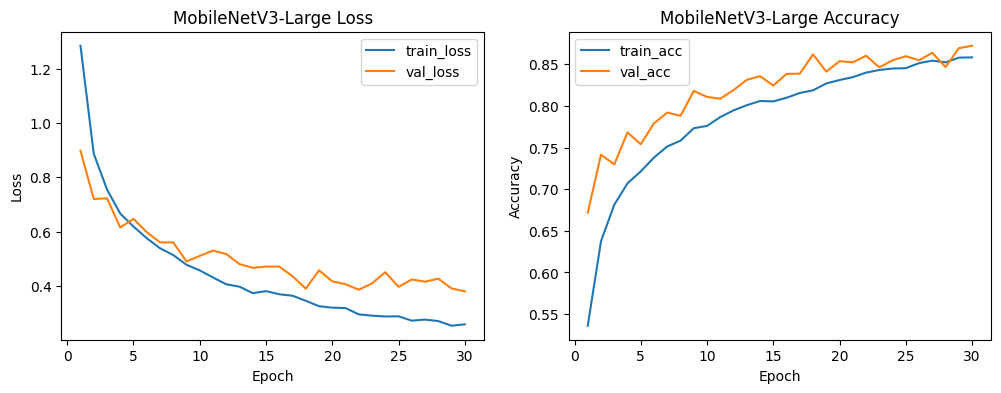

In [9]:
plot_history(history, model_name="MobileNetV3-Large")


In [10]:
# Load best model checkpoint (if needed) and run final evaluation on validation set
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    
    # Fix sklearn warnings by setting zero_division parameter
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

In [11]:
evaluate_model(model)

                               precision    recall  f1-score   support

            Actinic keratoses       0.63      0.76      0.69        86
         Basal cell carcinoma       0.88      0.85      0.87       332
Benign keratosis-like lesions       0.71      0.75      0.73       262
                   Chickenpox       0.95      0.96      0.96       112
                       Cowpox       1.00      1.00      1.00        99
               Dermatofibroma       0.74      0.87      0.80        23
                         HFMD       0.98      1.00      0.99       241
                      Healthy       0.99      0.98      0.99       171
                      Measles       1.00      0.99      0.99        82
             Melanocytic nevi       0.92      0.85      0.88      1287
                     Melanoma       0.71      0.78      0.74       452
                    Monkeypox       0.98      0.97      0.98       426
      Squamous cell carcinoma       0.57      0.74      0.64        62
     

Note: you may need to restart the kernel to use updated packages.
Test classes order: ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Melanocytic nevi', 'Melanoma', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Test size: 3674

Test set class distribution:
  Actinic keratoses: 88
  Basal cell carcinoma: 333
  Benign keratosis-like lesions: 263
  Chickenpox: 113
  Cowpox: 99
  Dermatofibroma: 25
  HFMD: 242
  Healthy: 171
  Measles: 83
  Melanocytic nevi: 1288
  Melanoma: 453
  Monkeypox: 426
  Squamous cell carcinoma: 64
  Vascular lesions: 26

✅ Loaded checkpoint: MobileNetV3-Large_best.pth

TEST SET EVALUATION RESULTS
Overall Accuracy: 0.875
F1 Score (Macro): 0.865
F1 Score (Weighted): 0.876

Detailed Classification Report:
                               precision    recall  f1-score   support

            Actinic keratoses       0.69      0.82      0.75        88
   

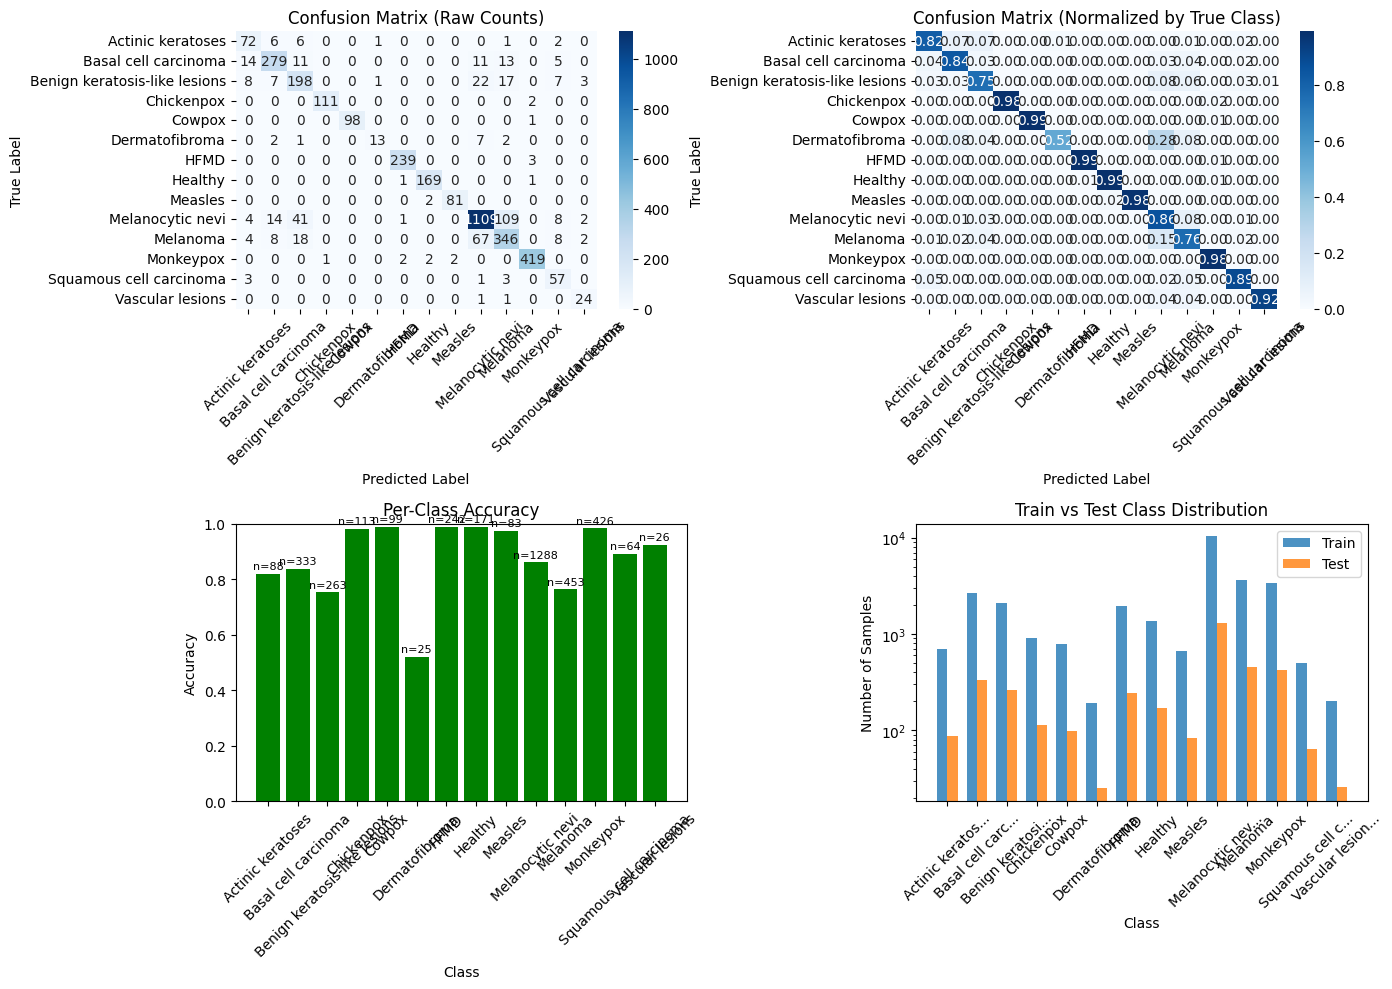


DIAGNOSTIC INFORMATION

Classes with poor performance (accuracy < 0.1):

Model's prediction bias (most frequently predicted classes):
  Melanocytic nevi: 1218 predictions (33.2%)
  Melanoma: 492 predictions (13.4%)
  Monkeypox: 426 predictions (11.6%)
  Basal cell carcinoma: 316 predictions (8.6%)
  Benign keratosis-like lesions: 275 predictions (7.5%)

Suggestions for improvement:
1. The model appears to be heavily biased toward certain classes (especially HFMD)
2. Consider data augmentation or resampling for underrepresented classes
3. Adjust class weights more aggressively
4. Consider using focal loss instead of weighted cross-entropy
5. Ensure test set class distribution matches expected real-world distribution

✅ Saved detailed predictions to: test_predictions_detailed.csv

Misclassification summary:
Total misclassified: 459/3674 (12.5%)
Most common misclassifications:
  Melanocytic nevi → Melanoma: 109 cases
  Melanoma → Melanocytic nevi: 67 cases
  Melanocytic nevi → Benign ker

In [12]:
# Test Set Evaluation with Improved Error Handling
%pip install pandas seaborn
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# path to test data 
test_dir = r"D:\archive\test"
# use same transforms as val_transforms to keep inputs consistent
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Test classes order:", test_dataset.classes)
print("Test size:", len(test_dataset))

# Check class distribution in test set
test_class_counts = {}
for _, label in test_dataset.samples:
    class_name = test_dataset.classes[label]
    test_class_counts[class_name] = test_class_counts.get(class_name, 0) + 1

print("\nTest set class distribution:")
for class_name, count in test_class_counts.items():
    print(f"  {class_name}: {count}")

# load best checkpoint (if you saved it during training)
ckpt_path = "MobileNetV3-Large_best.pth"   # adjust if different
try:
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    print(f"\n✅ Loaded checkpoint: {ckpt_path}")
except Exception as e:
    print(f"⚠️ Checkpoint load failed (using current model): {e}")

model.to(device)
model.eval()

y_true = []
y_pred = []
probs = []   # optional: predicted probabilities

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        ps = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())
        probs.extend(ps.cpu().numpy().tolist())

# Calculate metrics with zero_division parameter to fix warnings
print("\n" + "="*50)
print("TEST SET EVALUATION RESULTS")
print("="*50)

# Overall accuracy
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Overall Accuracy: {accuracy:.3f}")
print(f"F1 Score (Macro): {f1_macro:.3f}")
print(f"F1 Score (Weighted): {f1_weighted:.3f}")

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Raw Confusion Matrix:")
print(cm)

# Enhanced confusion matrix visualization
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
# Use seaborn for better heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.subplot(2, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Normalized by True Class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Class-wise performance analysis
plt.subplot(2, 2, 3)
class_accuracies = []
class_support = []
for i in range(len(class_names)):
    if cm[i].sum() > 0:  # Only if class has samples
        class_acc = cm[i, i] / cm[i].sum()
        class_accuracies.append(class_acc)
        class_support.append(cm[i].sum())
    else:
        class_accuracies.append(0)
        class_support.append(0)

bars = plt.bar(range(len(class_names)), class_accuracies, 
               color=['red' if acc < 0.1 else 'orange' if acc < 0.5 else 'green' 
                      for acc in class_accuracies])
plt.title("Per-Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.ylim(0, 1)

# Add support numbers on bars
for i, (bar, support) in enumerate(zip(bars, class_support)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'n={support}', ha='center', va='bottom', fontsize=8)

# Class distribution comparison
plt.subplot(2, 2, 4)
class_names_short = [name[:15] + '...' if len(name) > 15 else name for name in class_names]
# Get train counts from train_dataset if available
if 'train_dataset' in globals():
    train_class_counts = {}
    for _, label in train_dataset.samples:
        class_name = train_dataset.classes[label]
        train_class_counts[class_name] = train_class_counts.get(class_name, 0) + 1
    train_counts = [train_class_counts.get(class_names[i], 0) for i in range(len(class_names))]
else:
    train_counts = [0] * len(class_names)
test_counts = [test_class_counts.get(class_names[i], 0) for i in range(len(class_names))]

x = np.arange(len(class_names))
width = 0.35
plt.bar(x - width/2, train_counts, width, label='Train', alpha=0.8)
plt.bar(x + width/2, test_counts, width, label='Test', alpha=0.8)
plt.title("Train vs Test Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(x, class_names_short, rotation=45)
plt.legend()
plt.yscale('log')  # Log scale to better show differences

plt.tight_layout()
plt.show()

# Identify problematic classes
print("\n" + "="*50)
print("DIAGNOSTIC INFORMATION")
print("="*50)

print("\nClasses with poor performance (accuracy < 0.1):")
for i, (class_name, acc, support) in enumerate(zip(class_names, class_accuracies, class_support)):
    if acc < 0.1 and support > 0:
        print(f"  {class_name}: {acc:.3f} accuracy, {support} samples")
    elif support == 0:
        print(f"  {class_name}: No test samples available")

print("\nModel's prediction bias (most frequently predicted classes):")
pred_counts = np.bincount(y_pred, minlength=len(class_names))
for i in np.argsort(pred_counts)[::-1][:5]:  # Top 5 most predicted
    print(f"  {class_names[i]}: {pred_counts[i]} predictions ({pred_counts[i]/len(y_pred)*100:.1f}%)")

print("\nSuggestions for improvement:")
print("1. The model appears to be heavily biased toward certain classes (especially HFMD)")
print("2. Consider data augmentation or resampling for underrepresented classes")
print("3. Adjust class weights more aggressively")
print("4. Consider using focal loss instead of weighted cross-entropy")
print("5. Ensure test set class distribution matches expected real-world distribution")

# Save detailed results
filenames = [p[0] for p in test_dataset.samples]  # full relative paths
df = pd.DataFrame({
    "file": [os.path.basename(f) for f in filenames],  # Just filename, not full path
    "true_label": [class_names[i] for i in y_true],
    "pred_label": [class_names[i] for i in y_pred],
    "confidence": [round(float(np.max(p)), 4) for p in probs],
    "correct": [t == p for t, p in zip(y_true, y_pred)]
})

# Add per-class confidence statistics
df.to_csv("test_predictions_detailed.csv", index=False)
print(f"\n✅ Saved detailed predictions to: test_predictions_detailed.csv")

# Summary of misclassifications
print(f"\nMisclassification summary:")
misclassified = df[~df['correct']]
if len(misclassified) > 0:
    print(f"Total misclassified: {len(misclassified)}/{len(df)} ({len(misclassified)/len(df)*100:.1f}%)")
    print("Most common misclassifications:")
    misclass_pairs = misclassified.groupby(['true_label', 'pred_label']).size().sort_values(ascending=False)
    for (true_label, pred_label), count in misclass_pairs.head(10).items():
        print(f"  {true_label} → {pred_label}: {count} cases")
else:
    print("Perfect classification! (This is unlikely - please verify your data)")

## Notes and next steps
- Tune learning rates, batch size, augmentation.
- Consider 5-fold cross validation for robustness.
- Use mixed precision (torch.cuda.amp) to speed up training on large GPUs.
- Save final models and record results in a comparison table.